###Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

###Read CSV data into a DataFrame Object

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ISAA/creditcard.csv')
data = data.drop(['Time'] , axis=1)

In [ ]:
data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [ ]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

###Importing Modules

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

###Splitting of Dataset

In [ ]:
# Dividing the dataset into testing and validation sets (60/40 class distribution)
y_true=data['Class']
df_data=data.drop('Class',1)
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.4, random_state=42)

###Model Training and Prediction Functions

In [ ]:
# Train the model 5 times separately on 5 randomized samples of 10000 and add trained model to an model array
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

In [ ]:
## Prediction function
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

###Initialize Isolation forest model

In [ ]:
alg1=IsolationForest(n_estimators=100,
                     max_samples='auto',
                     contamination=0.01,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=-1,
                     random_state=42,
                     verbose=0)

In [ ]:
alg2=IsolationForest(n_estimators=1000,
                     max_samples='auto',
                     contamination=0.02,
                     max_features=1.0,
                     bootstrap=True,
                     n_jobs=-1,
                     random_state=42,
                     verbose=0)

###Training the Models

In [ ]:
if_mdlLst1=train(X_train,alg1)

In [ ]:
if_mdlLst2=train(X_train,alg2)

###Predicting Anomalies

In [ ]:
## With n_estimators == 100
if_y_pred1=predict(X_test,if_mdlLst1)
if_y_pred1=1-if_y_pred1

#Creating class labels based on decision function
if_y_pred1_class=if_y_pred1.copy()
if_y_pred1_class[if_y_pred1>=np.percentile(if_y_pred1,95)]=1
if_y_pred1_class[if_y_pred1<np.percentile(if_y_pred1,95)]=0

In [ ]:
# With n_estimators == 1000
if_y_pred2=predict(X_test,if_mdlLst2)
if_y_pred2=1-if_y_pred2

#Creating class labels based on decision function
if_y_pred2_class=if_y_pred2.copy()
if_y_pred2_class[if_y_pred2>=np.percentile(if_y_pred2,95)]=1
if_y_pred2_class[if_y_pred2<np.percentile(if_y_pred2,95)]=0

###Calculation of  ROC_AUC score

In [ ]:
# With n_estimators == 100
fpr1, tpr1, _1 = roc_curve(y_test, if_y_pred1_class)
# AUC
IF_auc1 = auc(fpr1, tpr1)
print(IF_auc1)

0.902372446071899
0.902372446071899


In [ ]:
# With n_estimators == 1000
fpr2, tpr2, _2 = roc_curve(y_test, if_y_pred2_class)
# AUC
IF_auc2 = auc(fpr2, tpr2)
print(IF_auc2)

0.8997502487247047
0.8997502487247047


###Confusion Matrix

In [ ]:
if_cm=confusion_matrix(y_test, if_y_pred2_class)

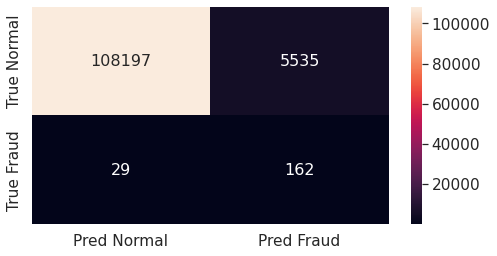

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#Automate Best Parameters

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ISAA/creditcard.csv')

([<matplotlib.patches.Wedge at 0x7f0e9fa54190>,
 [Text(-0.7820271852666787, -0.7735848250217141, '0'),
  Text(0.8531205024736381, 0.8439107821678352, '1')],
 [Text(-0.4265602828727338, -0.4219553591027531, '99.83%'),
  Text(0.4976536264429556, 0.49228128959790385, '0.17%')])

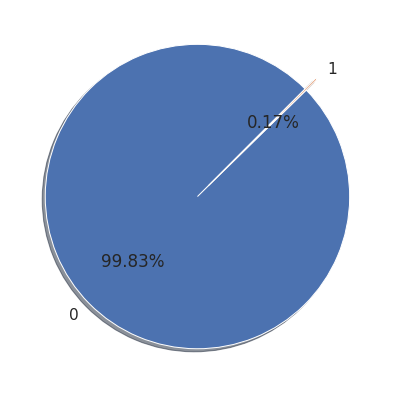

In [ ]:
# Plot the balance of class labels
fig1, ax1 = plt.subplots(figsize=(14, 7))
plt.pie(df[['Class']].value_counts(), explode=[0,0.1], labels=[0,1], autopct='%1.2f%%', shadow=True, startangle=45)

In [ ]:
df_classes = df['Class']
df_train = df.drop(['Class'], axis=1)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_train, df_classes, test_size=0.40, random_state=42)

Best: [0.00055457 0.0005901  0.0004603  0.0004524  0.00049564 0.00046415
 0.00018033 0.00018031 0.00019689 0.00019271 0.00021308 0.00018434], 
using {'bootstrap': True, 'contamination': 0.01, 'max_features': 1.0, 'n_estimators': 100}
Isolation Forest (tuned) model
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    112810
           1       0.64      0.11      0.19      1113

    accuracy                           0.99    113923
   macro avg       0.82      0.55      0.59    113923
weighted avg       0.99      0.99      0.99    113923

None


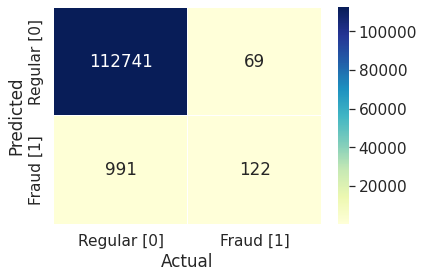

In [ ]:
# Define the parameter grid
n_estimators=[50, 100]
max_features=[1.0, 5, 10]
bootstrap=[True]
contamination_rate=[0.01,0.05]
param_grid = dict(n_estimators=n_estimators, max_features=max_features,contamination=contamination_rate,bootstrap=bootstrap)

# Build the gridsearch
model_isf = IsolationForest(n_estimators=n_estimators,
                            max_features=max_features,
                            contamination=contamination_rate,
                            bootstrap=True,
                            n_jobs=-1)

# Define an f1_scorer
f1sc = make_scorer(f1_score, average='macro')

grid = GridSearchCV(estimator=model_isf, param_grid=param_grid, cv = 2, scoring=f1sc)
grid_results = grid.fit(X=X_train, y=y_train)

# Summarize the results in a readable format
print("Best: {0}, \nusing {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

# Evaluate model performance
model_name = 'Isolation Forest (tuned)'
print(f'{model_name} model')

best_model = grid_results.best_estimator_
map_labels = True # if True - maps 1 to 0 and -1 to 1 - not required for scikit-learn knn models
'''model_score1 = measure_performance(best_model, X_test, y_test, map_labels)
performance_df = performance_df.append({'model_name':model_name,
                                    'f1_score': model_score1[0],
                                    'precision': model_score1[1],
                                    'recall': model_score1[2]}, ignore_index=True)'''

def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset
    df_pred_test = X_test.copy()
    df_pred_test['Class'] = y_test
    df_pred_test['Pred'] = model.predict(X_test)
    if map_labels:
        df_pred_test['Pred'] = df_pred_test['Pred'].map({1: 0, -1: 1})
    #df_pred_test['Outlier_Score'] = model.decision_function(X_test)

    # measure performance
    y_true = df_pred_test['Class']
    x_pred = df_pred_test['Pred']
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Regular [0]', 'Fraud [1]'],
                yticklabels=['Regular [0]', 'Fraud [1]'],
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')

    print(classification_report(x_pred, y_true))
print(measure_performance(best_model, X_test, y_test, map_labels))